## This notebook takes the CSV file of image data and preps it for the model, then trains the model



In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import time
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, AveragePooling2D, MaxPool2D, Conv2D, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')

In [2]:
df = pd.read_csv('final.csv',index_col=False)
df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023,class
0,231,105,24,24,24,24,24,24,24,24,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,52,108,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,18,40,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,56,172,52,170,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df['class'].value_counts()

1     6327
2     6210
12    6021
11    5443
3     2469
0     1810
4     1640
5     1008
6      812
7      753
9      742
8      731
10     600
Name: class, dtype: int64

In [4]:
IMG_W = 32
IMG_H = 32
CHANNELS = 1

### Viewing an image from the csv file

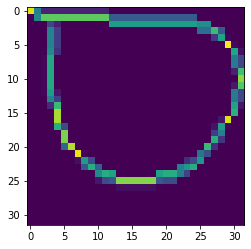

In [5]:
image = df.iloc[0]
im = np.array(image, dtype=np.uint8)
im.resize(IMG_H,IMG_W,CHANNELS) 
plt.imshow(im)
plt.show()

### Dropping 'class' column

In [6]:
labels = df.iloc[:,-1:]
labels_np = np.array(labels)
labels_as_cat = to_categorical(labels_np,num_classes=13)

In [7]:
labels_as_cat[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [8]:
df_no_class = df.iloc[:,:-1]
df_no_class.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel1014,pixel1015,pixel1016,pixel1017,pixel1018,pixel1019,pixel1020,pixel1021,pixel1022,pixel1023
0,231,105,24,24,24,24,24,24,24,24,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,52,108,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,18,40,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,56,172,52,170,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
df_no_class.shape

(34566, 1024)

### Reshaping the data to fit the model 


In [10]:
l=[]
for i in range(len(df_no_class)):
    l.append(np.array(df_no_class[i:i+1]).reshape(IMG_H,IMG_W,CHANNELS))
X = np.array(l)

In [11]:
X.shape

(34566, 32, 32, 1)

In [12]:
np.array(labels)

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [12],
       [12],
       [12]])

In [20]:
# from sklearn.utils import class_weight

# weights = class_weight.compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(labels),
#     y=labels.values.reshape(-1)
# )
# class_weights = {i : weights[i] for i in range(len(weights))}
# class_weights

{0: 1.4690182745431364,
 1: 0.42025020972389393,
 2: 0.42816796729840206,
 3: 1.0769230769230769,
 4: 1.6212945590994372,
 5: 2.6378205128205128,
 6: 3.2745358090185674,
 7: 3.531106343855348,
 8: 3.6373776702094074,
 9: 3.583454281567489,
 10: 4.431538461538461,
 11: 0.4885032292711881,
 12: 0.44160821739297074}

In [27]:
import math

# labels_dict : {ind_label: count_label}
# mu : parameter to tune 

def create_class_weight(labels_dict,mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()
    
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
    
    return class_weight

# random labels_dict
labels_dict = dict(df['class'].value_counts())

class_weights = create_class_weight(labels_dict)

### Creating the model

In [33]:
# METRICS = [
#       keras.metrics.TruePositives(name='tp'),
#       keras.metrics.FalsePositives(name='fp'),
#       keras.metrics.TrueNegatives(name='tn'),
#       keras.metrics.FalseNegatives(name='fn'), 
#       keras.metrics.BinaryAccuracy(name='accuracy'),
#       keras.metrics.Precision(name='precision'),
#       keras.metrics.Recall(name='recall'),
#       keras.metrics.AUC(name='auc'),
#       keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
# ]

model = Sequential([
    Conv2D(filters=6, kernel_size=(5, 5), activation='relu', input_shape=(IMG_H,IMG_W,CHANNELS)),
    AveragePooling2D(),
    Conv2D(filters=16, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(),
    Conv2D(filters=32, kernel_size=(5, 5), activation='relu'),
    AveragePooling2D(),
    Flatten(),
    Dense(units=120, activation='relu'),
    Dense(units=84, activation='relu'),
    Dense(units=13, activation='softmax')])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 400)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 120)               48120     
_________________________________________________________________
dense_9 (Dense)              (None, 84)               

In [34]:
es = EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(X, labels_as_cat, batch_size=64, epochs=20, 
          validation_split=0.05, callbacks=[], 
          class_weight=class_weights, verbose=1)

Epoch 1/20
514/514 [==============================] - 11s 21ms/step - loss: 1.6324 - accuracy: 0.6806 - val_loss: 0.0358 - val_accuracy: 0.9942
Epoch 2/20
514/514 [==============================] - 10s 20ms/step - loss: 0.2585 - accuracy: 0.9426 - val_loss: 0.0266 - val_accuracy: 0.9965
Epoch 3/20
514/514 [==============================] - 10s 20ms/step - loss: 0.1548 - accuracy: 0.9660 - val_loss: 0.0379 - val_accuracy: 0.9936
Epoch 4/20
514/514 [==============================] - 10s 20ms/step - loss: 0.1185 - accuracy: 0.9723 - val_loss: 0.0464 - val_accuracy: 0.9919
Epoch 5/20
514/514 [==============================] - 10s 20ms/step - loss: 0.0871 - accuracy: 0.9813 - val_loss: 0.0452 - val_accuracy: 0.9931
Epoch 6/20
514/514 [==============================] - 12s 24ms/step - loss: 0.0671 - accuracy: 0.9852 - val_loss: 0.0484 - val_accuracy: 0.9936
Epoch 7/20
514/514 [==============================] - 12s 23ms/step - loss: 0.0573 - accuracy: 0.9867 - val_loss: 0.0427 - val_accuracy:

In [ ]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [35]:
NAME = f'model/model32x32-{int(time.time())}'
model.save(NAME)

INFO:tensorflow:Assets written to: model/model32x32-1639265480/assets


INFO:tensorflow:Assets written to: model/model32x32-1639265480/assets
